# Compute Classifier Metrics

Author: Jess Ewald

The classification pipeline now outputs the probability of the positive class for each cell profile, along with the labels and classifier info. This allows us to compute any metric of interest. Here, we compute possible metrics of interest:

- AUC-ROC
- macro-averaged F1 score
- balanced accuracy

We analyze the results with respect to the clinvar annotations. This version is with the updated metadata annotations.

In [2]:
# imports
import polars as pl
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import collections
import plotnine as plotnine

from importlib import reload
import displayImages as di

reload(di)

In [3]:
# paths
pipeline = "profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr"
snakemake_dir = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake"
res_b7 = f"{snakemake_dir}/outputs/results/2024_01_23_Batch_7/{pipeline}"
res_b8 = f"{snakemake_dir}/outputs/results/2024_02_06_Batch_8/{pipeline}"
metrics_dir = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent_updatedmeta"

## Compute classifier metrics

In [23]:
# read in bb classifier info
info_b7 = pl.read_csv(f"{res_b7}/classifier_info.csv")
info_b7 = info_b7.with_columns(
    (pl.col("trainsize_1") / (pl.col("trainsize_0") + pl.col("trainsize_1"))).alias(
        "train_prob_1"
    ),
    (pl.col("testsize_1") / (pl.col("testsize_0") + pl.col("testsize_1"))).alias(
        "test_prob_1"
    ),
)

info_b8 = pl.read_csv(f"{res_b8}/classifier_info.csv")
info_b8 = info_b8.with_columns(
    (pl.col("trainsize_1") / (pl.col("trainsize_0") + pl.col("trainsize_1"))).alias(
        "train_prob_1"
    ),
    (pl.col("testsize_1") / (pl.col("testsize_0") + pl.col("testsize_1"))).alias(
        "test_prob_1"
    ),
)

info = pl.concat([info_b7, info_b8])

In [24]:
# classifier predictions
preds_b8 = pl.scan_parquet(f"{res_b8}/predictions.parquet")
preds_b8 = preds_b8.with_columns(pl.lit("batch8").alias("Batch")).collect()

preds_b7 = pl.scan_parquet(f"{res_b7}/predictions.parquet")
preds_b7 = preds_b7.with_columns(pl.lit("batch7").alias("Batch")).collect()


preds = pl.concat([preds_b7, preds_b8]).with_columns(
    pl.concat_str(
        [pl.col("Classifier_ID"), pl.col("Metadata_Protein"), pl.col("Batch")],
        separator="_",
    ).alias("Full_Classifier_ID")
)

In [25]:
# Define a function to compute metrics for each group
def compute_aubprc(auprc, prior):
    return (auprc * (1 - prior)) / ((auprc * (1 - prior)) + ((1 - auprc) * prior))


def compute_metrics(group):
    y_true = group["Label"].to_numpy()
    y_prob = group["Prediction"].to_numpy()
    y_pred = (y_prob > 0.5).astype(int)
    prior = sum(y_true == 1) / len(y_true)

    class_ID = group["Classifier_ID"].unique()[0]

    # Compute AUROC
    auroc = roc_auc_score(y_true, y_prob)

    # Compute AUPRC
    auprc = average_precision_score(y_true, y_prob)
    aubprc = compute_aubprc(auprc, prior)

    # Compute macro-averaged F1 score
    macro_f1 = f1_score(y_true, y_pred, average="macro")

    # Compute sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Compute balanced accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)

    return {
        "AUROC": auroc,
        "AUPRC": auprc,
        "AUBPRC": aubprc,
        "Macro_F1": macro_f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Balanced_Accuracy": balanced_acc,
        "Classifier_ID": class_ID,
    }


In [26]:
# Initialize an empty list to store the results
results = []
classIDs = preds.select("Full_Classifier_ID").to_series().unique().to_list()

# Group by Classifier_ID and compute metrics for each group
for id in tqdm(classIDs):
    metrics = compute_metrics(preds.filter(pl.col("Full_Classifier_ID") == id))
    metrics["Full_Classifier_ID"] = id
    results.append(metrics)

# Convert the results to a Polars DataFrame
metrics_df = pl.DataFrame(results)

# Add classifier info and save
metrics_df = metrics_df.join(info, on="Classifier_ID")
metrics_df = metrics_df.with_columns(
    (
        pl.max_horizontal(["trainsize_0", "trainsize_1"])
        / pl.min_horizontal(["trainsize_0", "trainsize_1"])
    ).alias("Training_imbalance"),
    (
        pl.max_horizontal(["testsize_0", "testsize_1"])
        / pl.min_horizontal(["testsize_0", "testsize_1"])
    ).alias("Testing_imbalance"),
)
metrics_df.write_csv(f"{metrics_dir}/metrics.csv")

  2%|▏         | 199/9742 [00:05<04:04, 39.09it/s]


KeyboardInterrupt: 

In [7]:
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")

<Figure size 1000x800 with 0 Axes>

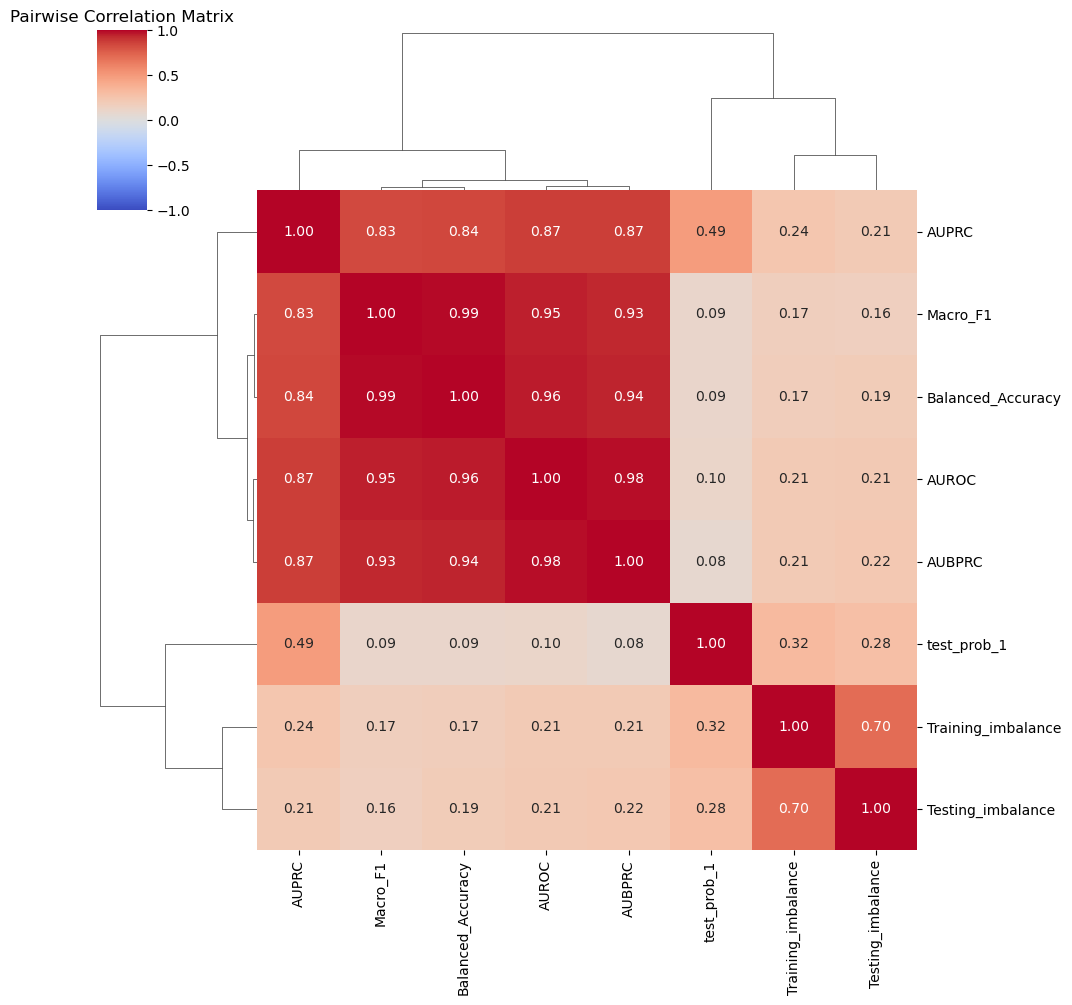

In [8]:
# Analyze pairwise correlation between metrics and test set imbalance
metrics_corr = (
    metrics_df.select([
        "AUROC",
        "AUPRC",
        "AUBPRC",
        "Macro_F1",
        "Balanced_Accuracy",
        "test_prob_1",
        "Training_imbalance",
        "Testing_imbalance",
    ])
    .to_pandas()
    .corr()
)

plt.figure(figsize=(10, 8))
sns.clustermap(metrics_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Pairwise Correlation Matrix")
plt.show()

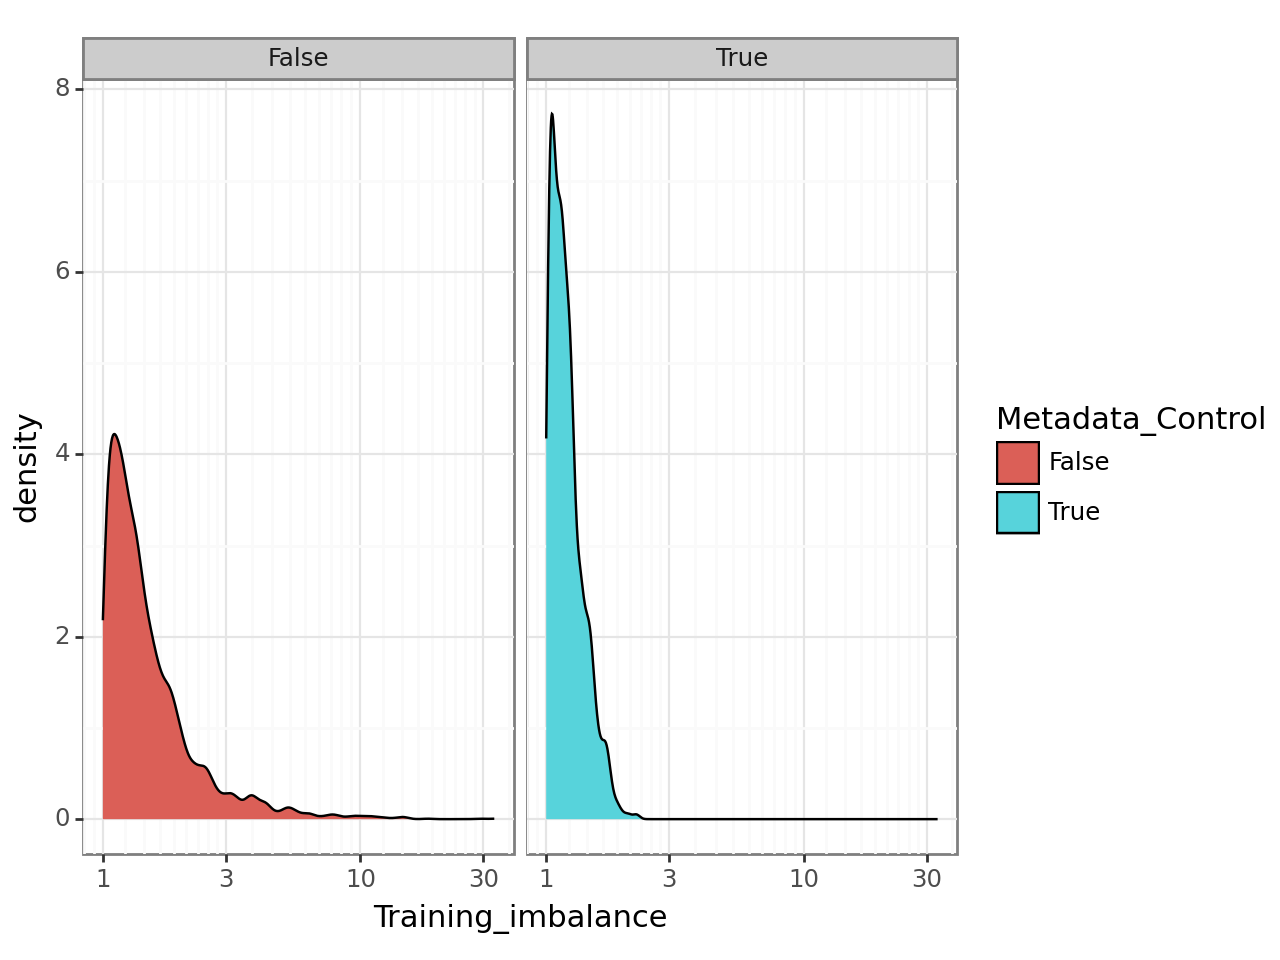

<Figure Size: (640 x 480)>

In [9]:
from plotnine import ggplot, aes, facet_wrap, scale_x_log10, theme_bw, geom_density

(
    ggplot(metrics_df, aes(x="Training_imbalance", fill="Metadata_Control"))
    + geom_density()
    + facet_wrap("Metadata_Control")
    + scale_x_log10()
    + theme_bw()
)

# This plot shows that in the training data, the controls (blue) are far more balanced than the WT-VAR (pink).
# To really prove that this is actual impact of density on features and not simply training class imbalance, I could downsample before training
# If the relationships hold, then we should still see the correlation between well cell count and classifier metrics.

In [10]:
metrics_df = metrics_df.with_columns(
    pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
    .then(pl.lit("localization"))
    .otherwise(pl.lit("morphology"))
    .alias("Classifier_type"),
    pl.when(pl.col("Full_Classifier_ID").str.contains("B7A"))
    .then(pl.lit("batch7"))
    .otherwise(pl.lit("batch8"))
    .alias("Batch"),
    pl.col("Plate").str.slice(13, 7).str.replace("R.*_", "").alias("Allele_set"),
)

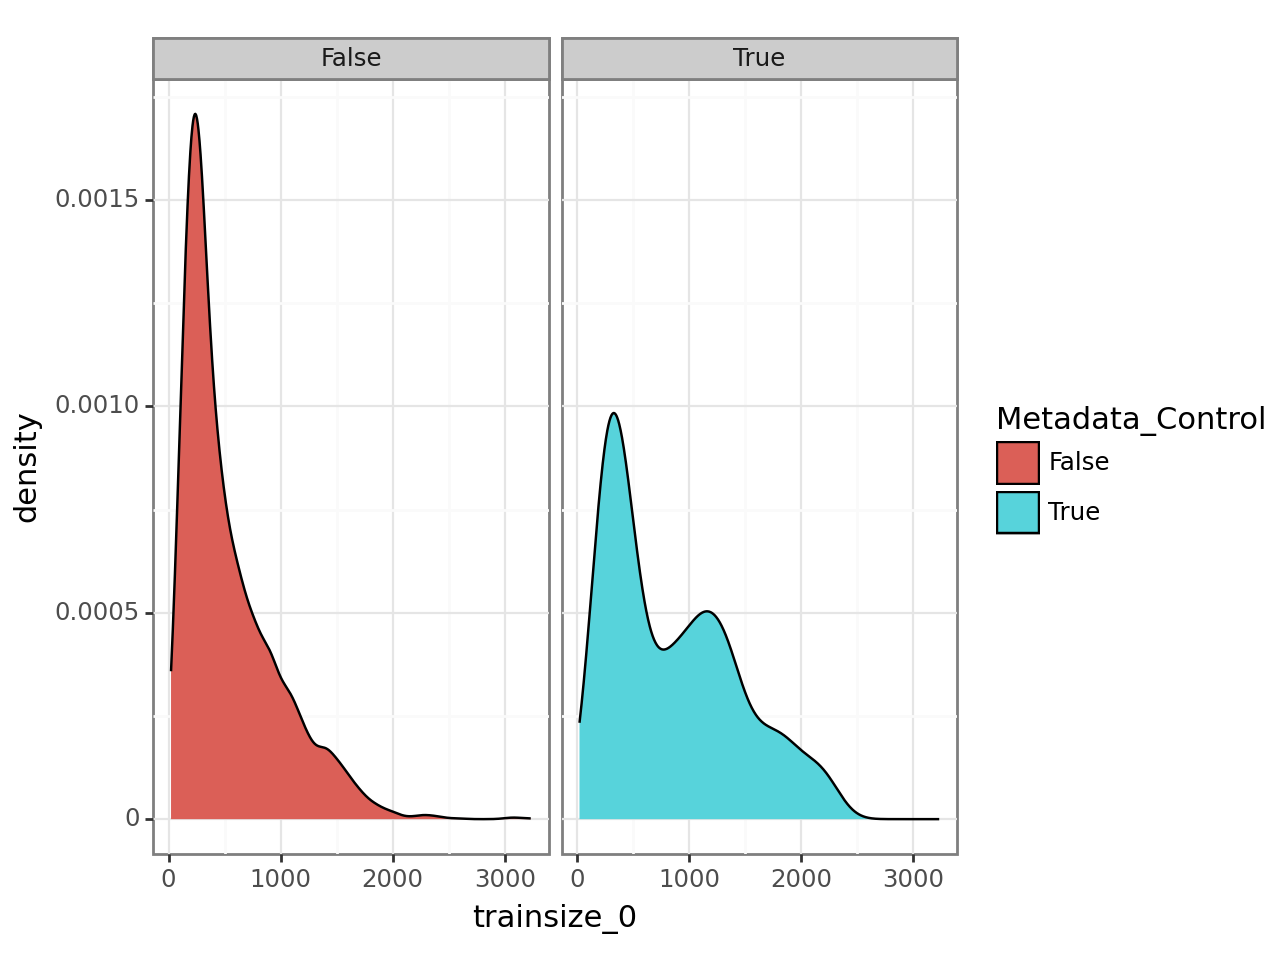

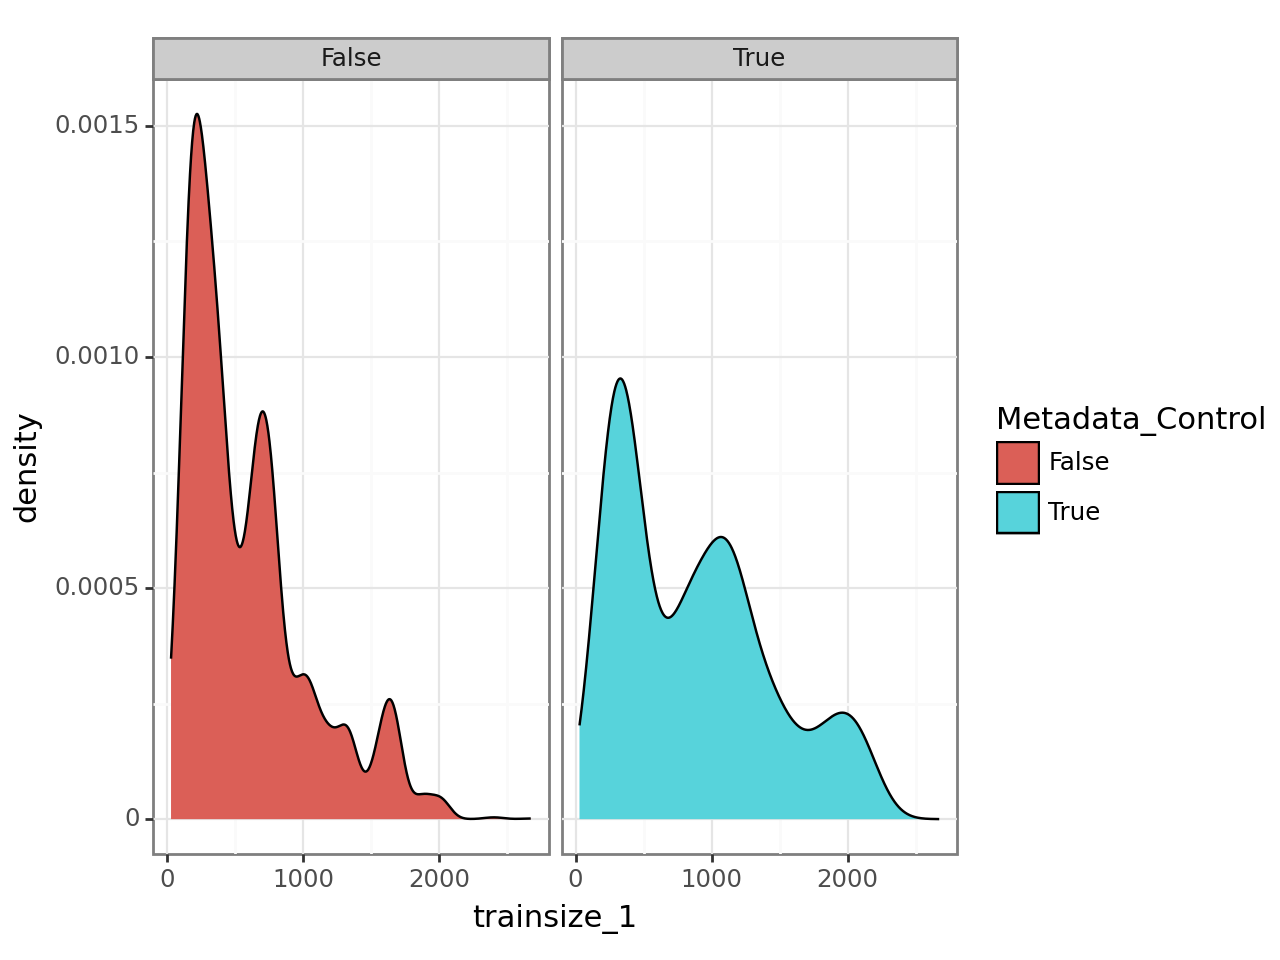

In [11]:
# Here we see that the distribution of training cell count is quite comparable between the WT-VAR and CTRL-CTRL pairs

from plotnine import ggplot, aes, facet_wrap, theme_bw, geom_density

plot1 = (
    ggplot(
        metrics_df.filter(pl.col("Classifier_type") == "localization"),
        aes(x="trainsize_0", fill="Metadata_Control"),
    )
    + geom_density()
    + facet_wrap("Metadata_Control")
    + theme_bw()
)
print(plot1)

plot2 = (
    ggplot(
        metrics_df.filter(pl.col("Classifier_type") == "localization"),
        aes(x="trainsize_1", fill="Metadata_Control"),
    )
    + geom_density()
    + facet_wrap("Metadata_Control")
    + theme_bw()
)
print(plot2)

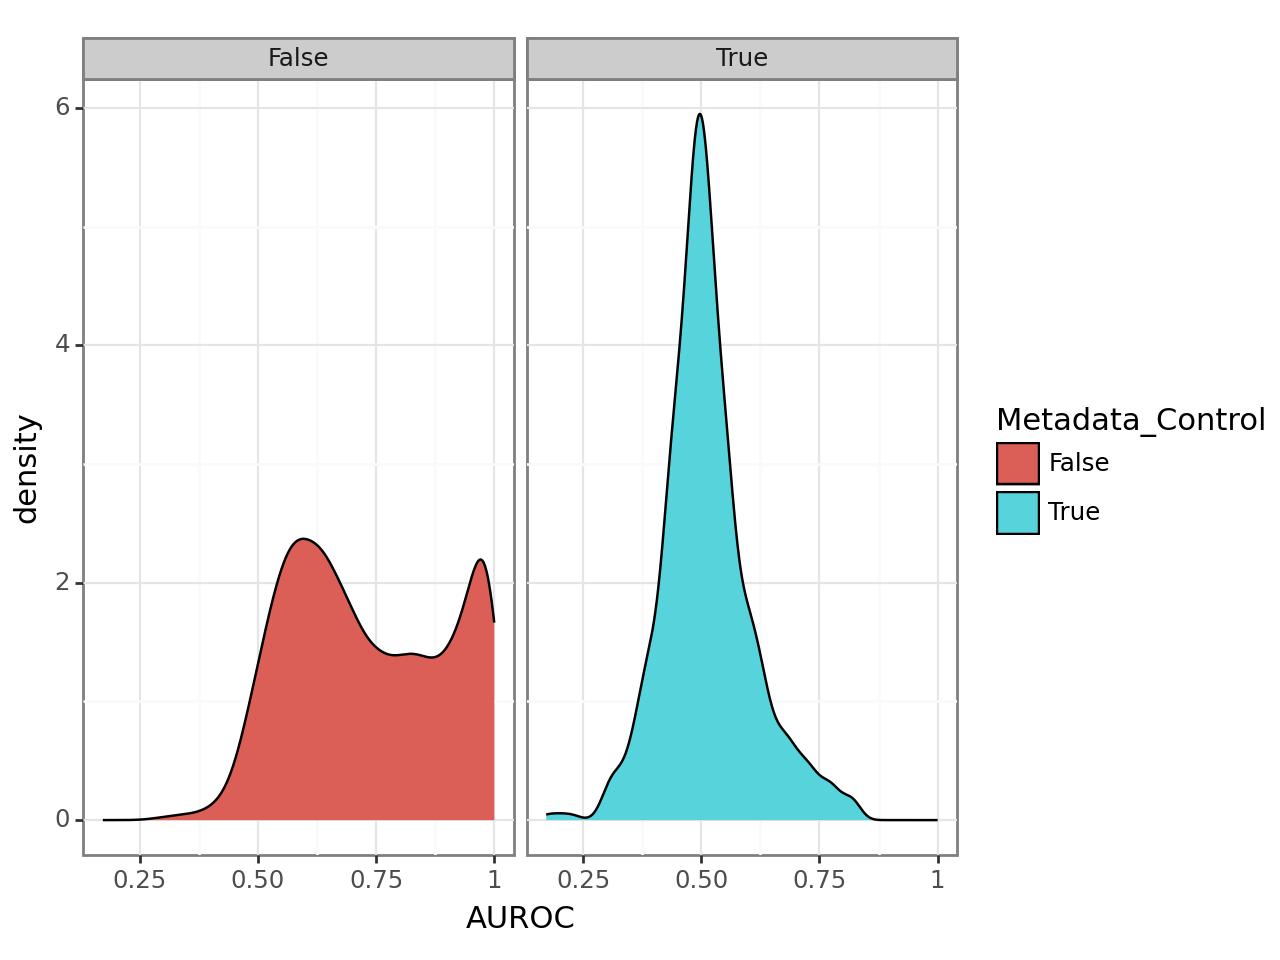

<Figure Size: (640 x 480)>

In [12]:
from plotnine import ggplot, aes, facet_wrap, theme_bw, geom_density

(
    ggplot(
        metrics_df.filter(pl.col("Classifier_type") == "localization"),
        aes(x="AUROC", fill="Metadata_Control"),
    )
    + geom_density()
    + facet_wrap("Metadata_Control")
    + theme_bw()
)

In [13]:
imbalance_thresh = 10

print(metrics_df.shape)
print(metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).shape)

print(len(metrics_df.select("allele_0").to_series().unique().to_list()))
print(
    len(
        metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh)
        .select("allele_0")
        .to_series()
        .unique()
        .to_list()
    )
)

(9742, 26)
(9698, 26)
604
602


Next, look at metrics across replicates within each batch, and also across batches (compare metrics aggregated across replicates). 

In [14]:
metrics_summary = (
    metrics_df.select([
        "AUROC",
        "AUPRC",
        "AUBPRC",
        "Macro_F1",
        "Balanced_Accuracy",
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .group_by([
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .agg([
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .mean()
        .suffix("_mean"),
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .median()
        .suffix("_median"),
    ])
    .with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))
)


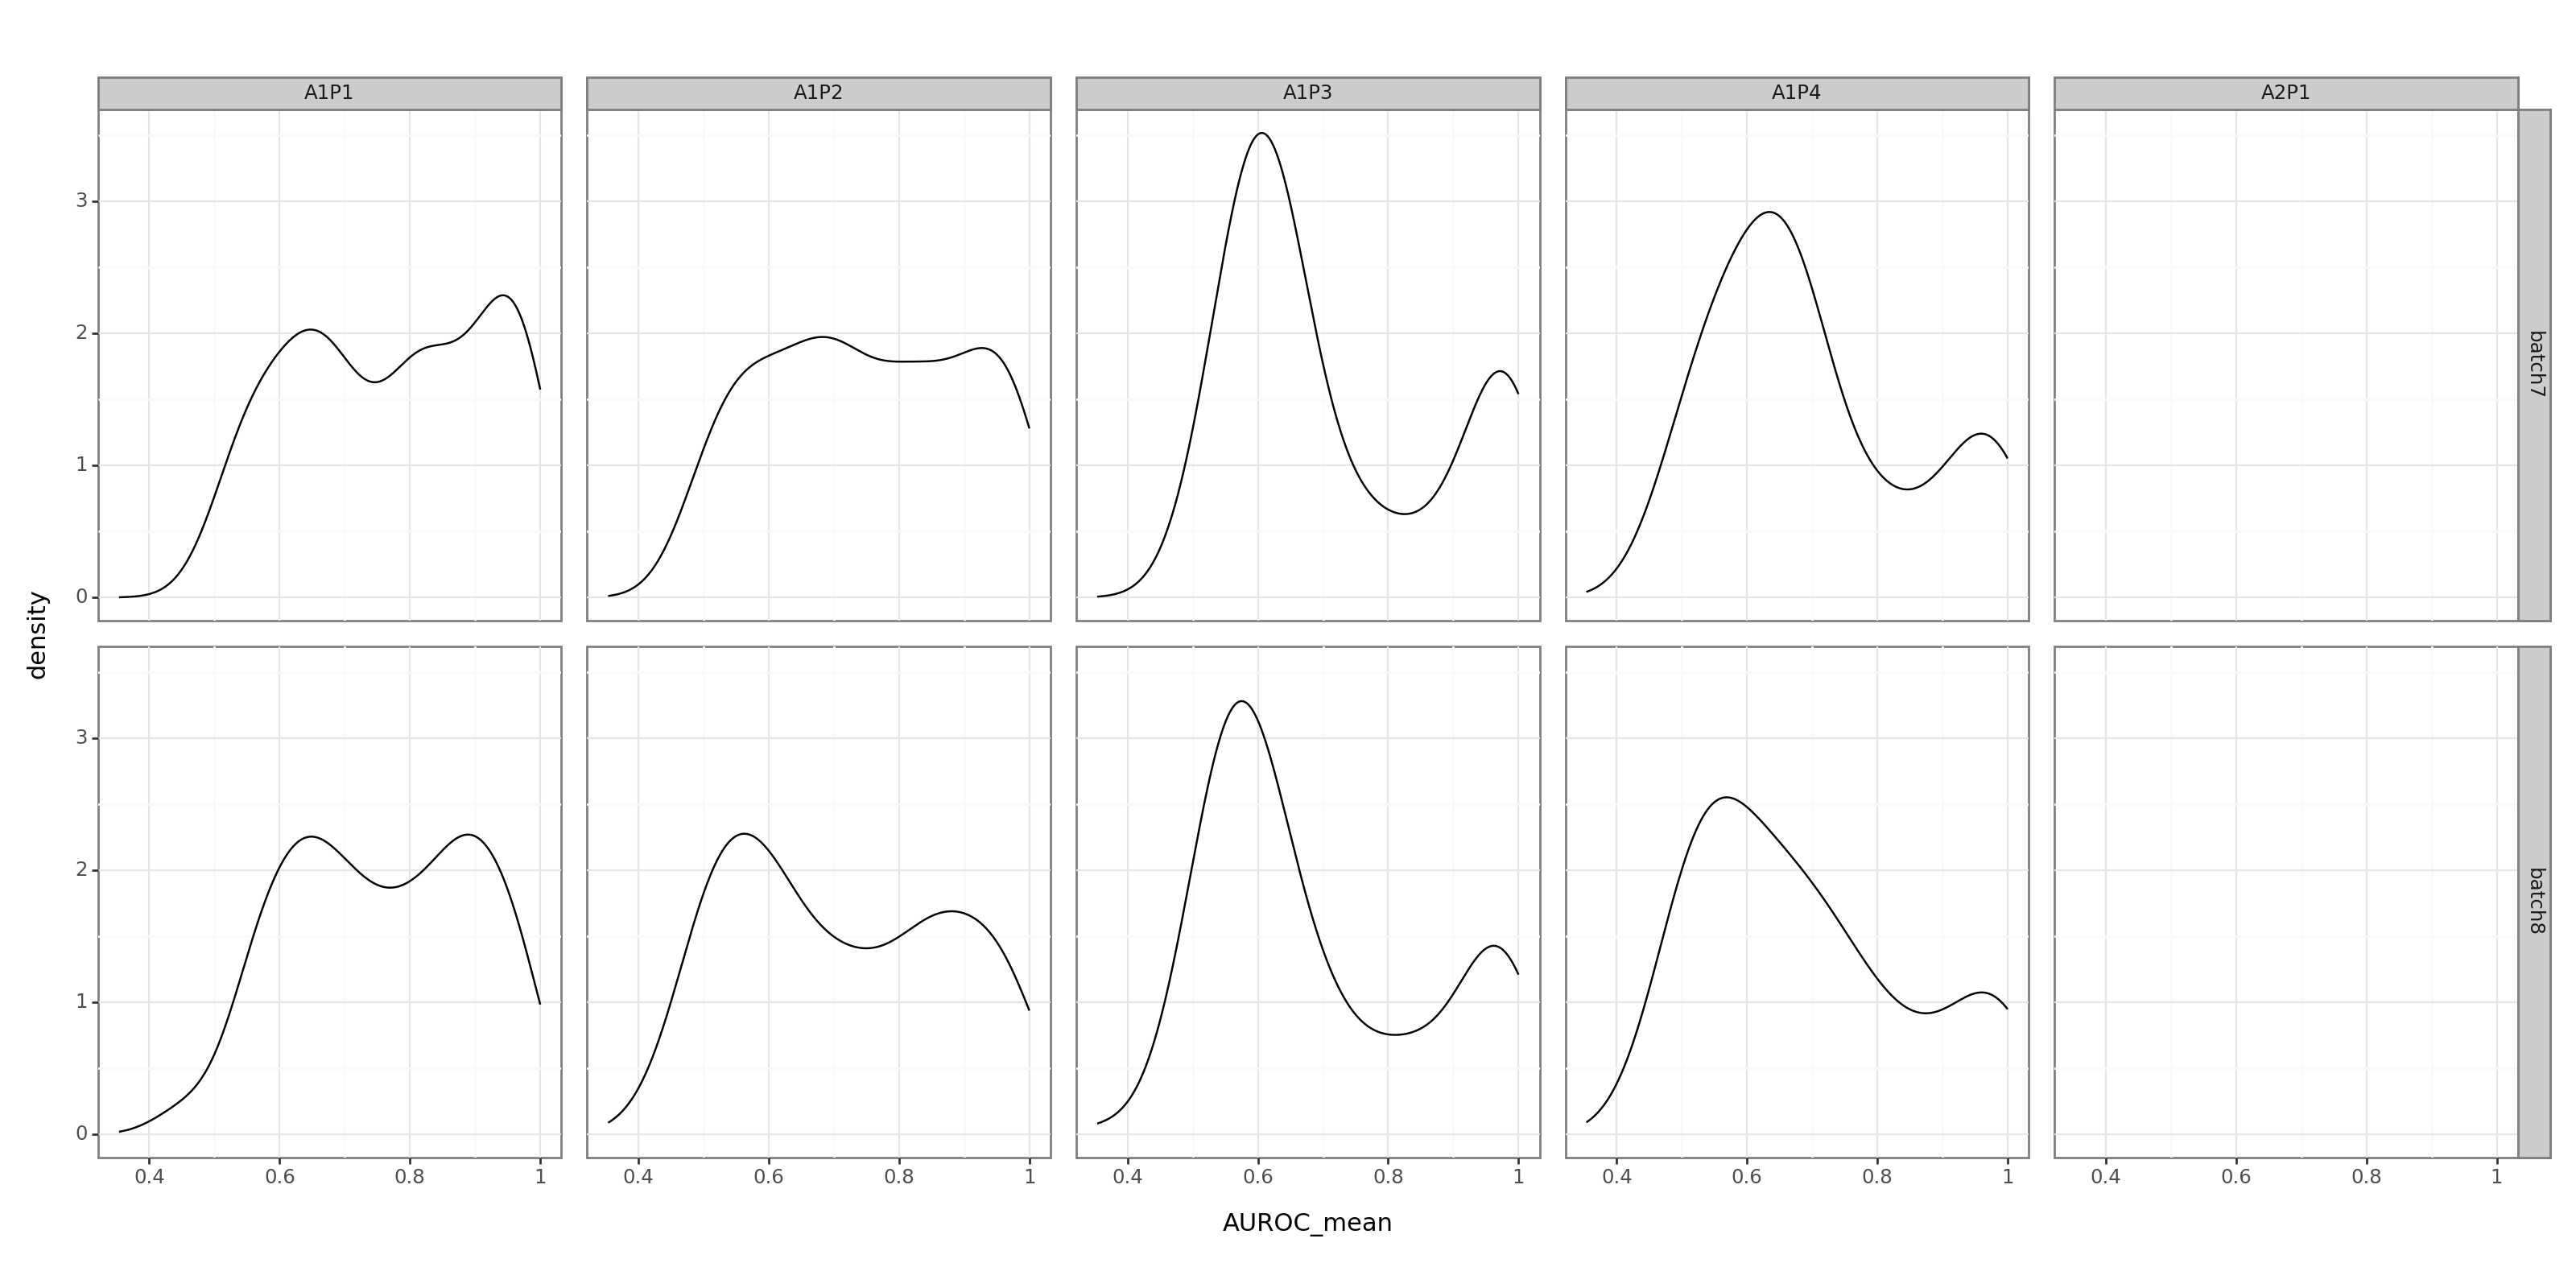

In [15]:
# Compare across allele sets
from plotnine import geom_point, facet_grid, theme_bw, ggplot, aes, xlab

plotnine.options.figure_size = (16, 8)
plot1 = (
    ggplot(
        metrics_summary.filter(
            (pl.col("Metadata_Control") == "false")
            & (pl.col("Classifier_type") == "localization")
        ),
        aes(x="AUROC_mean"),
    )
    + geom_density()
    + theme_bw()
    + facet_grid("Batch ~ Allele_set")
)
print(plot1)

In [16]:
# pivot to have separate column for batch 7 and batch 8
metrics_summary = metrics_summary.melt(
    id_vars=["Classifier_type", "Metadata_Control", "allele_0", "Batch", "Allele_set"],
    value_vars=[
        col
        for col in metrics_summary.columns
        if col
        not in [
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ]
    ],
    value_name="Value",
    variable_name="Metric",
).pivot(
    index=["Classifier_type", "Metadata_Control", "allele_0", "Metric", "Allele_set"],
    columns="Batch",
    values="Value",
)

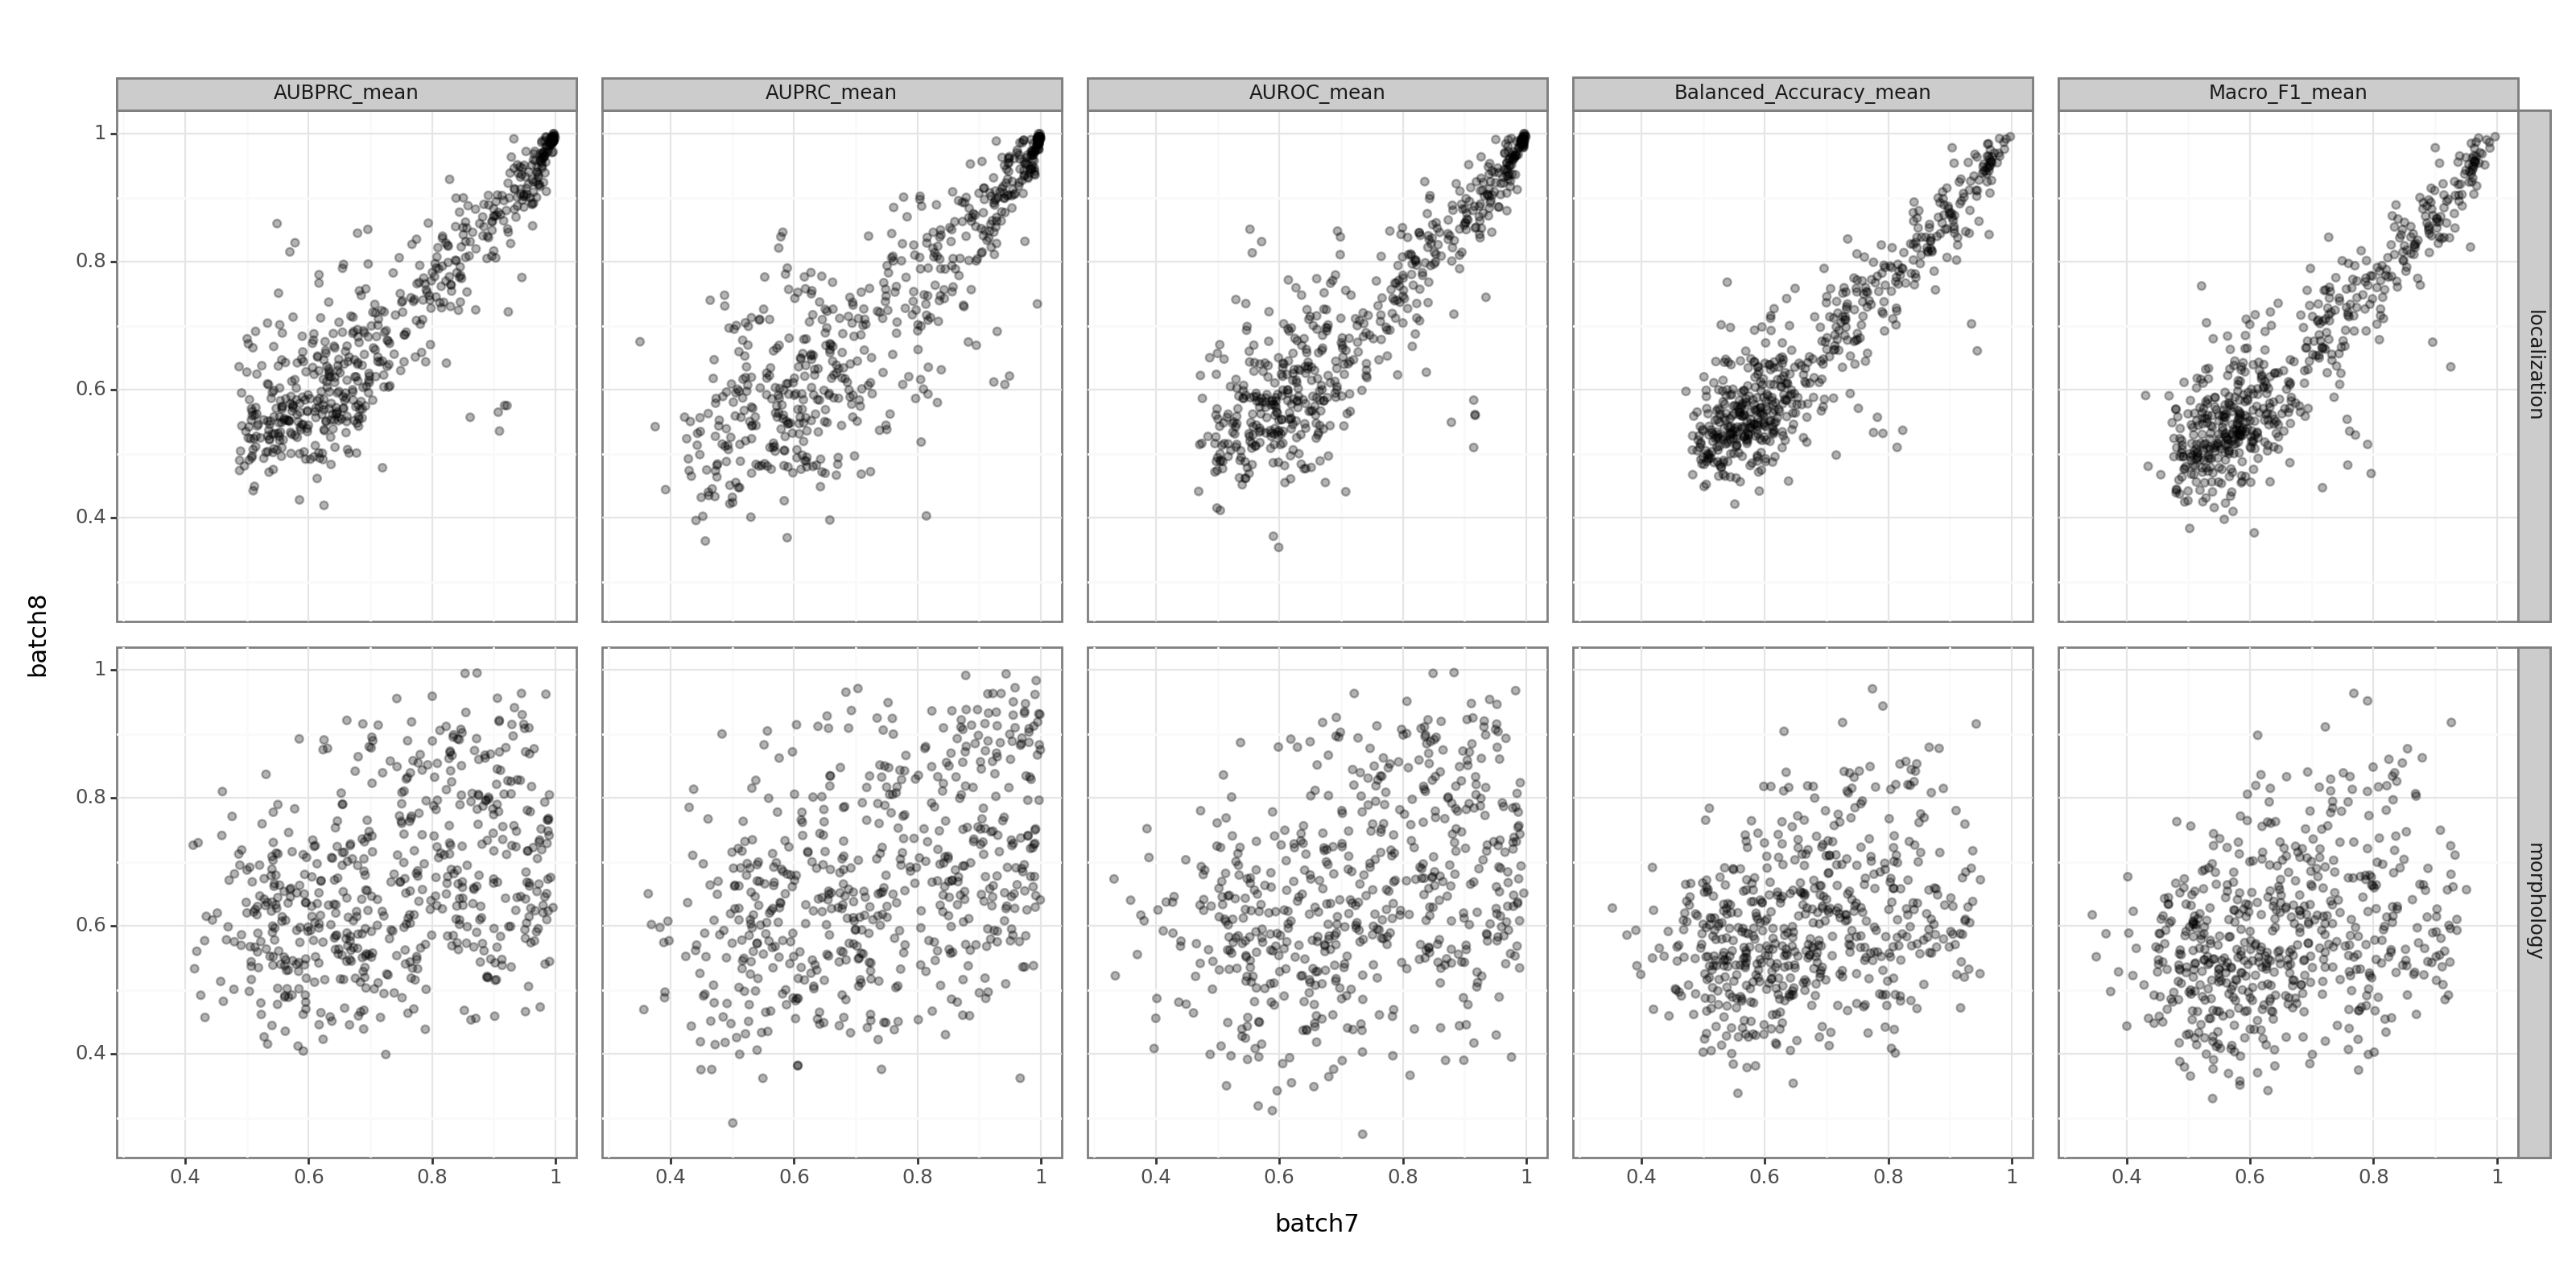

<Figure Size: (1600 x 800)>

In [17]:
plotnine.options.figure_size = (16, 8)
(
    ggplot(
        metrics_summary.filter(pl.col("Metric").str.contains("mean")),
        aes(x="batch7", y="batch8"),
    )
    + geom_point(alpha=0.3)
    + theme_bw()
    + facet_grid("Classifier_type ~ Metric", "free")
)

In [18]:
# try after filtering based on imbalance
imbalance_thresh = 10
metrics_summary = (
    metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh)
    .select([
        "AUROC",
        "AUPRC",
        "AUBPRC",
        "Macro_F1",
        "Balanced_Accuracy",
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .group_by([
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .agg([
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .mean()
        .suffix("_mean"),
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .median()
        .suffix("_median"),
    ])
    .with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))
)

metrics_summary = metrics_summary.melt(
    id_vars=["Classifier_type", "Metadata_Control", "allele_0", "Batch", "Allele_set"],
    value_vars=[
        col
        for col in metrics_summary.columns
        if col
        not in [
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ]
    ],
    value_name="Value",
    variable_name="Metric",
).pivot(
    index=[
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Metric",
        "Allele_set",
    ],  # Preserving these columns as indexes
    columns="Batch",
    values="Value",
)


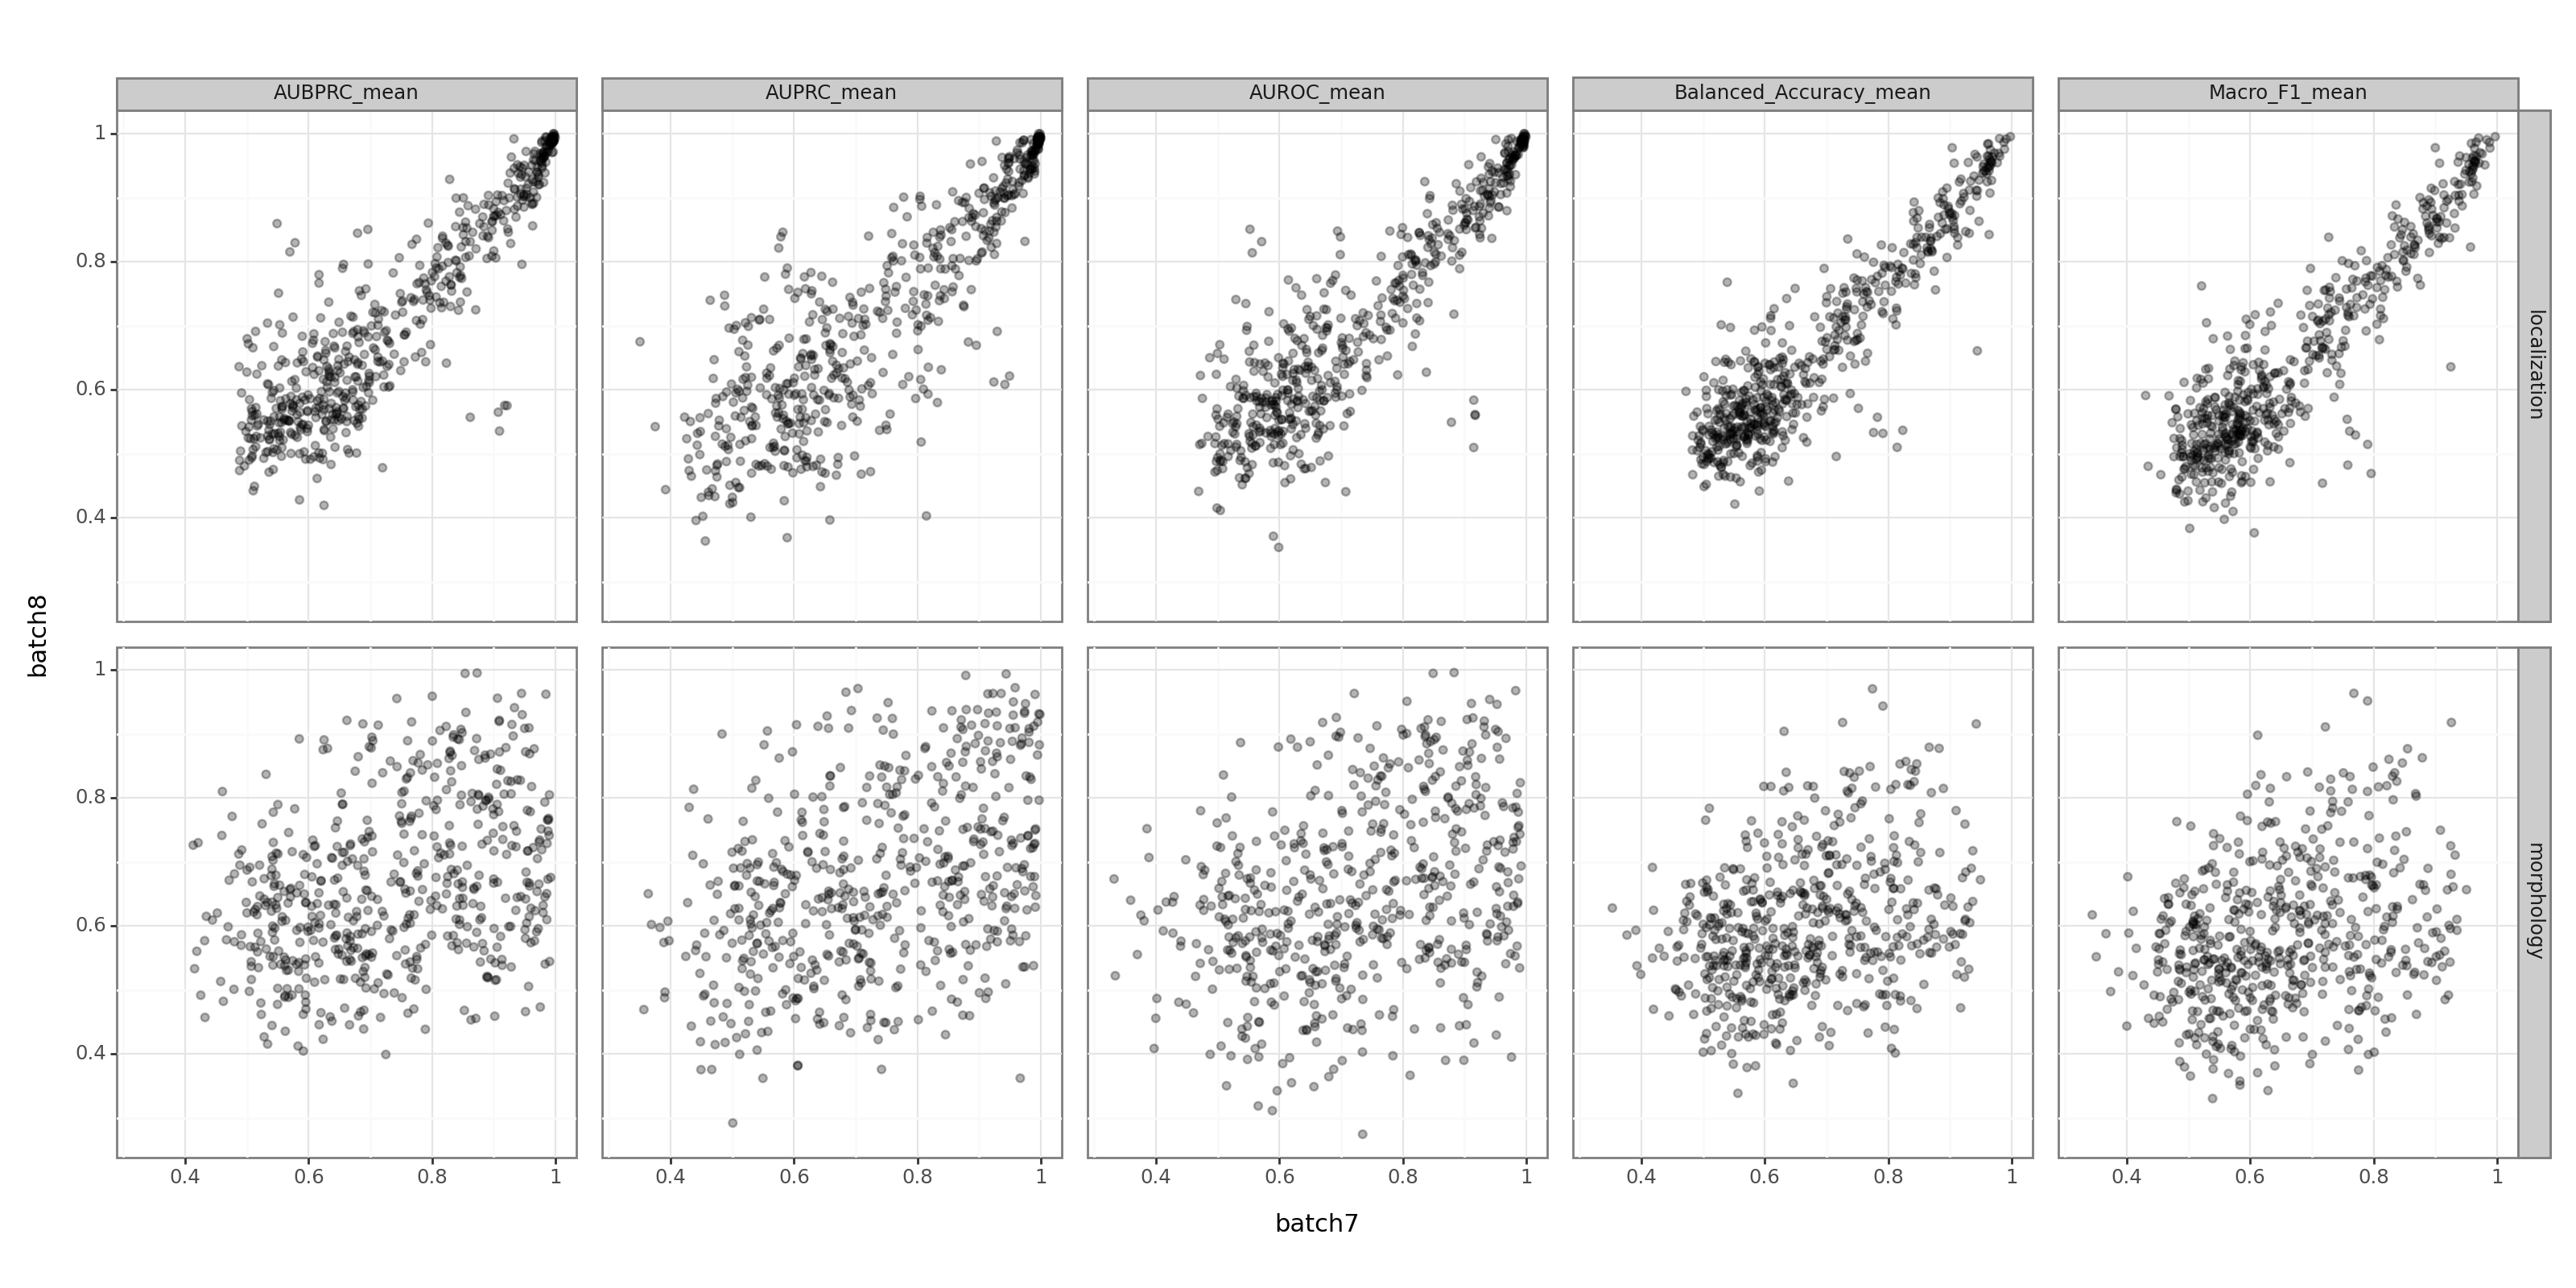

<Figure Size: (1600 x 800)>

In [19]:
plotnine.options.figure_size = (16, 8)
(
    ggplot(
        metrics_summary.filter(pl.col("Metric").str.contains("mean")),
        aes(x="batch7", y="batch8"),
    )
    + geom_point(alpha=0.3)
    + theme_bw()
    + facet_grid("Classifier_type ~ Metric", "free")
)

## Final results start here

In [4]:
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")
thresh = 3  # previously 10

metrics_df = metrics_df.with_columns(
    pl.col("Plate").str.slice(13, 7).str.replace("R.*_", "").alias("Allele_set")
)

metrics_df = metrics_df.with_columns(
    pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
    .then(pl.lit("localization"))
    .otherwise(pl.lit("morphology"))
    .alias("Classifier_type"),
    pl.when(pl.col("Full_Classifier_ID").str.contains("B7A"))
    .then(pl.lit("batch7"))
    .otherwise(pl.lit("batch8"))
    .alias("Batch"),
)

metrics_ctrl = (
    metrics_df.filter(
        (pl.col("Training_imbalance") < thresh) & (pl.col("Metadata_Control"))
    )
    .select(["Classifier_type", "Batch", "AUROC"])
    .group_by(["Classifier_type", "Batch"])
    .quantile(0.99)
).rename({"AUROC": "AUROC_thresh"})

print(metrics_ctrl)


shape: (4, 3)
┌─────────────────┬────────┬──────────────┐
│ Classifier_type ┆ Batch  ┆ AUROC_thresh │
│ ---             ┆ ---    ┆ ---          │
│ str             ┆ str    ┆ f64          │
╞═════════════════╪════════╪══════════════╡
│ morphology      ┆ batch8 ┆ 0.991648     │
│ morphology      ┆ batch7 ┆ 0.971686     │
│ localization    ┆ batch7 ┆ 0.719226     │
│ localization    ┆ batch8 ┆ 0.819394     │
└─────────────────┴────────┴──────────────┘


In [5]:
# Merge with metrics_df and decide whether it passed the threshold
metrics_df = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])

In [6]:
# Must be at least min_class_num classifiers per batch
# Number of classifiers is the same for localization and morph, so just use morph
min_class_num = 2

classifier_count = (
    metrics_df.filter(
        (pl.col("Training_imbalance") < thresh)
        & (~pl.col("Metadata_Control"))
        & (pl.col("Classifier_type") == "localization")
    )
    .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
    .agg([pl.count().alias("Number_classifiers")])
)
classifier_count = classifier_count.pivot(
    index=["allele_0", "allele_1", "Allele_set"],
    columns="Batch",
    values="Number_classifiers",
)

print(classifier_count.shape)
print(len(classifier_count.select("allele_0").to_series().unique().to_list()))
print(len(classifier_count.select("allele_1").to_series().unique().to_list()))

classifier_count = classifier_count.filter(
    (pl.col("batch7") >= min_class_num) & (pl.col("batch8") >= min_class_num)
)

print(classifier_count.shape)
print(len(classifier_count.select("allele_0").to_series().unique().to_list()))
print(len(classifier_count.select("allele_1").to_series().unique().to_list()))

# filter based on this
keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
metrics_df = metrics_df.filter(
    ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
)


(573, 5)
573
113
(471, 5)
471
102


In [7]:
metrics_wtvar = (
    (
        metrics_df.filter(
            (pl.col("Training_imbalance") < thresh) & (~pl.col("Metadata_Control"))
        )
    )
    .select([
        "AUROC",
        "Classifier_type",
        "Batch",
        "AUROC_thresh",
        "allele_0",
        "trainsize_0",
        "testsize_0",
        "trainsize_1",
        "testsize_1",
        "Allele_set",
        "Training_imbalance",
    ])
    .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
    .agg([
        pl.all()
        .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
        .mean()
        .suffix("_mean")
    ])
)

metrics_wtvar.write_csv(f"{metrics_dir}/metrics_summary.csv")

In [13]:
# split into morphology and localization, and count the proportion of classifiers that surpass the 0.99 NULL F1 score
morph_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "morphology")
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")
print(local_wtvar.shape)

# Analyze wrt clinvar annotations
clinvar = pl.read_csv("../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("allele_0")
)

local_wtvar = local_wtvar.join(
    clinvar.select(["allele_0", "clinvar_cs"]), on="allele_0"
)
print(local_wtvar.shape)

(942, 11)
(964, 12)


In [14]:
# Alleles must be mislocalized in both batches
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("Mislocalized")
).unique()

local_wtvar = local_wtvar.pivot(
    index=["allele_0", "Allele_set", "clinvar_cs"],
    columns="Batch",
    values="Mislocalized",
).with_columns(
    ((pl.col("batch7") == 1) & (pl.col("batch8") == 1)).alias(
        "Mislocalized_both_batches"
    )
)

In [15]:
# count %  mislocalized by label type
benign_local = local_wtvar.filter(pl.col("clinvar_cs") == "Benign")
vus_local = local_wtvar.filter(pl.col("clinvar_cs") == "VUS")
path_local = local_wtvar.filter(pl.col("clinvar_cs") == "Pathogenic")

print("Benign")
print(
    benign_local.filter(pl.col("Mislocalized_both_batches")).shape[0]
    / benign_local.shape[0]
)
print(
    "# misloc: "
    + str(benign_local.filter(pl.col("Mislocalized_both_batches")).shape[0])
)
print("total #: " + str(benign_local.shape[0]))
print("\n")

print("VUS")
print(
    vus_local.filter(pl.col("Mislocalized_both_batches")).shape[0] / vus_local.shape[0]
)
print(
    "# misloc: " + str(vus_local.filter(pl.col("Mislocalized_both_batches")).shape[0])
)
print("total #: " + str(vus_local.shape[0]))
print("\n")

print("Pathogenic")
print(
    path_local.filter(pl.col("Mislocalized_both_batches")).shape[0]
    / path_local.shape[0]
)
print(
    "# misloc: " + str(path_local.filter(pl.col("Mislocalized_both_batches")).shape[0])
)
print("total #: " + str(path_local.shape[0]))

Benign
0.16666666666666666
# misloc: 9
total #: 54


VUS
0.2911392405063291
# misloc: 23
total #: 79


Pathogenic
0.3465909090909091
# misloc: 61
total #: 176


In [16]:
misloc_benign = (
    benign_local.filter(pl.col("Mislocalized_both_batches"))
    .select("allele_0")
    .to_series()
    .to_list()
)
benign_local.filter(pl.col("Mislocalized_both_batches"))

shape: (9, 6)
┌──────────────────┬────────────┬────────────┬────────┬────────┬───────────────────────────┐
│ allele_0         ┆ Allele_set ┆ clinvar_cs ┆ batch7 ┆ batch8 ┆ Mislocalized_both_batches │
│ ---              ┆ ---        ┆ ---        ┆ ---    ┆ ---    ┆ ---                       │
│ str              ┆ str        ┆ str        ┆ i32    ┆ i32    ┆ bool                      │
╞══════════════════╪════════════╪════════════╪════════╪════════╪═══════════════════════════╡
│ LIG4_Ala857Thr   ┆ A1P2       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ COMP_Ala171Thr   ┆ A1P1       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ LIG4_Thr9Ile     ┆ A1P2       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ RASA1_Glu70Gly   ┆ A1P3       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ EFHC1_Met448Thr  ┆ A1P1       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ RAD51D_Glu233Gly ┆ A1P3       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ XRCC2_Phe270Val  ┆ A1P4       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ PNPO_Arg116Gln   ┆ A1P3       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
│ NAA10_Arg195Cys  ┆ A1P3       ┆ Benign     ┆ 1      ┆ 1      ┆ true                      │
└──────────────────┴────────────┴────────────┴────────┴────────┴───────────────────────────┘

In [17]:
misloc_path = (
    path_local.filter(pl.col("Mislocalized_both_batches"))
    .select("allele_0")
    .to_series()
    .to_list()
)[0:5]
misloc_path

['COMP_Asp511Glu',
 'COMP_Asp271His',
 'DCX_Ser129Leu',
 'HPRT1_His204Asp',
 'PNPO_Arg95Cys']

In [18]:
misloc_all = (
    local_wtvar.filter(pl.col("Mislocalized_both_batches"))
    .select("allele_0")
    .to_series()
    .to_list()
)
len(misloc_all)

137

In [19]:
from importlib import reload
import displayImages as di

reload(di)

<module 'displayImages' from '/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/7.downstream_analysis_jess/notebooks/displayImages.py'>

In [20]:
pm_df = pl.scan_parquet(
    "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
)
meta_cols = [
    "Metadata_Well",
    "Metadata_Plate",
    "Metadata_gene_allele",
    "Metadata_node_type",
]
pm_df = pm_df.select(meta_cols).unique().collect()

In [21]:
pm_df = pm_df.rename({
    "Metadata_Well": "Well",
    "Metadata_Plate": "Plate",
    "Metadata_gene_allele": "Allele",
    "Metadata_node_type": "control_type",
}).with_columns(
    pl.lit("05").alias("Site"),
    pl.col("Plate").str.slice(11, 6).alias("Batch"),
    pl.col("Plate").str.slice(11, 9).alias("Plate"),
)

rep_df = pl.DataFrame({
    "Batch": [
        "B7A1R1",
        "B7A1R1",
        "B7A1R1",
        "B7A1R1",
        "B7A2R1",
        "B7A2R1",
        "B7A2R1",
        "B7A2R1",
        "B8A1R2",
        "B8A1R2",
        "B8A1R2",
        "B8A1R2",
        "B8A2R2",
        "B8A2R2",
        "B8A2R2",
        "B8A2R2",
    ],
    "Replicate": [
        "T1",
        "T2",
        "T3",
        "T4",
        "T1",
        "T2",
        "T3",
        "T4",
        "T1",
        "T2",
        "T3",
        "T4",
        "T1",
        "T2",
        "T3",
        "T4",
    ],
})

pm_df = pm_df.join(rep_df, on="Batch")

In [35]:
# Plot
# plot the 5th site from all images, organized by classifier
counter = 0
plot_dir = "/dgx1nas1/storage/data/jess/varchamp/images/B7B8_misloc"
for var_allele in tqdm(misloc_benign):
    padded_counter = str(counter).zfill(3)

    gfp_nm = f"{str(padded_counter)}_{var_allele}_GFP.png"

    wt_allele = var_allele.split("_")[0]
    plot_img = (
        pm_df.filter(
            ((pl.col("Allele") == var_allele) | (pl.col("Allele") == wt_allele))
        )
        .unique()
        .sort(["Allele", "Batch", "Replicate"])
    )

    # filter to keep only images where there is a single WT-VAR pair in each plate
    plates_img = (
        plot_img.select(["Plate", "control_type"])
        .unique()
        .select("Plate")
        .to_series()
        .to_list()
    )
    plates_img = collections.Counter(plates_img)
    plates_img = (
        pl.DataFrame(plates_img)
        .melt()
        .filter(pl.col("value") == 2)
        .select("variable")
        .to_series()
        .to_list()
    )
    plot_img = plot_img.filter(pl.col("Plate").is_in(plates_img))

    di.plotMultiImages(
        plot_img, "GFP", 0.99, 4, display=False, plotpath=f"{plot_dir}/{gfp_nm}"
    )
    counter = counter + 1

100%|██████████| 9/9 [02:59<00:00, 19.89s/it]


In [22]:
# Plot all mislocalized alleles
# plot the 5th site from all images, organized by classifier
counter = 0
plot_dir = "/dgx1nas1/storage/data/jess/varchamp/images/B7B8_mislocalized"
for var_allele in tqdm(misloc_all):
    padded_counter = str(counter).zfill(3)

    gfp_nm = f"{str(padded_counter)}_{var_allele}_GFP.png"

    wt_allele = var_allele.split("_")[0]
    plot_img = (
        pm_df.filter(
            ((pl.col("Allele") == var_allele) | (pl.col("Allele") == wt_allele))
        )
        .unique()
        .sort(["Allele", "Batch", "Replicate"])
    )

    # filter to keep only images where there is a single WT-VAR pair in each plate
    plates_img = (
        plot_img.select(["Plate", "control_type"])
        .unique()
        .select("Plate")
        .to_series()
        .to_list()
    )
    plates_img = collections.Counter(plates_img)
    plates_img = (
        pl.DataFrame(plates_img)
        .melt()
        .filter(pl.col("value") == 2)
        .select("variable")
        .to_series()
        .to_list()
    )
    plot_img = plot_img.filter(pl.col("Plate").is_in(plates_img))

    di.plotMultiImages(
        plot_img, "GFP", 0.99, 4, display=False, plotpath=f"{plot_dir}/{gfp_nm}"
    )
    counter = counter + 1

100%|██████████| 137/137 [31:41<00:00, 13.88s/it]
